In [1]:
import numpy as np
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
import PIL
import tensorflow as tf
import random
import re
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
#disable_eager_execution()
enable_eager_execution()

In [6]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
import tensorflow_datasets as tfds

In [7]:
from __future__ import print_function
import argparse
from tensorflow.keras.layers import Input
import scipy.misc

#from configs import bcolors
from utils import *
import tensorflow_model_optimization as tfmot

In [30]:
import tensorflow.keras.backend as backend

# Load Dataset - Imagenet2012 validation set 50000 images

In [9]:
def preprocess_image(features):
    """Preprocesses the given image.

      Args:
        image: `Tensor` representing an image of arbitrary size.

      Returns:
        A preprocessed image `Tensor` of range [0, 1].
  """
    image = features["image"]
    image = tf.image.resize(image,[224,224])
    
    features["image"] = image
    return features["image"], features["label"]

In [10]:
def extract(ith_image, ds):
    for i, features in enumerate(ds):
        if ith_image < 50 and i == 0:
            image = np.expand_dims(features[0].numpy()[ith_image], axis=0)
            label = features[1].numpy()[ith_image]
            break
        
        elif i == np.floor(ith_image/50):
            image = np.expand_dims(features[0].numpy()[ith_image%50], axis=0)
            label = features[1].numpy()[ith_image%50]
            break
    return image, label

In [11]:
BATCH_SIZE = 50
es = {'file_name': tf.TensorSpec(shape=(), dtype=tf.string, name=None),
 'image': tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
 'label': tf.TensorSpec(shape=(), dtype=tf.int64, name=None)}
mydataset = tf.data.experimental.load("/local/rcs/wei/End3kImagePerClass/",es).map(preprocess_image).batch(BATCH_SIZE).prefetch(1)

# Original Models

In [12]:
import tensorflow_model_optimization as tfmot

In [13]:
model = ResNet50(input_shape=(224, 224,3))

In [14]:
model.load_weights("./fp_model_40_resnet50.h5")

In [15]:
q_model = tfmot.quantization.keras.quantize_model(ResNet50(input_shape=(224, 224,3)))

In [16]:
q_model.load_weights("./q_model_40_resnet50.h5")

In [17]:
distilled_model = ResNet50(input_tensor = q_model.input)

In [18]:
distilled_model.load_weights("./distilled_fp_model_40_resnet50.h5")

# Constructed Models

In [19]:
from SemibbModel import * 

In [20]:
s_model = buildmodel('fp')

In [18]:
s_model.load_weights("./segregated_fp_model_40_resnet_2_v2.h5")

In [21]:
s_model = ResNet101(input_shape=(224, 224,3))

In [22]:
dq_model = buildmodel('fp', input_t = s_model.input)

In [23]:
#dq_model = buildmodel('fp', input_t = distilled_model.input)

# Ad Attack

In [146]:
image,label = extract(1000,mydataset)

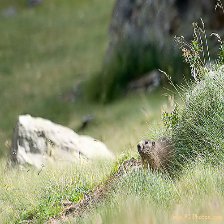

336

In [147]:
pil_img = tf.keras.preprocessing.image.array_to_img(image[0,:,:,:])
from IPython.display import Image
display(pil_img)
display(label)

In [148]:
c = 1e2
grad_iterations = 20
step = 1
epsilon = 8
preprocess = tf.keras.applications.resnet.preprocess_input

In [149]:
input_image = tf.identity(image[0,:,:,:])
orig_img = tf.identity(input_image)
orig_label = label
A = 0
pred1, pred2= s_model.predict(preprocess(input_image)[None,...]), dq_model.predict(preprocess(input_image)[None,...])
label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
if label1 != label or label2 != label1:
    print("bad image")

In [150]:
test_image = preprocess(input_image)[None,...]
pred1, pred2= s_model.predict(test_image), dq_model.predict(test_image)
label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
pred3, pred4= model.predict(test_image), q_model.predict(test_image)
label3, label4 = np.argmax(pred3[0]), np.argmax(pred4[0])
label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
pred5= distilled_model.predict(test_image)
label5= np.argmax(pred5[0])
    
print('model: '+ str(tf.keras.applications.resnet.decode_predictions(pred3, top=5)[0][0]))
print('q_model: '+ str(tf.keras.applications.resnet.decode_predictions(pred4, top=5)[0][0]))
print('s_model: '+ str(tf.keras.applications.resnet.decode_predictions(pred1, top=5)[0][0]))
print('dq_model: '+ str(tf.keras.applications.resnet.decode_predictions(pred2, top=5)[0][0]))
print('distilled_model: '+ str(tf.keras.applications.resnet.decode_predictions(pred5,top=5)[0][0]))

model: ('n02361337', 'marmot', 0.43813345)
q_model: ('n02361337', 'marmot', 0.22258829)
s_model: ('n02361337', 'marmot', 0.8586472)
dq_model: ('n02361337', 'marmot', 0.27834985)
distilled_model: ('n02361337', 'marmot', 0.41969383)


In [151]:
for iters in range(0,grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = backend.mean(s_model(preprocess(input_image)[None,...], training = False)[..., orig_label])
        loss2 = backend.mean(dq_model(preprocess(input_image)[None,...], training = False)[..., orig_label])
        final_loss = backend.mean(loss1 - c*loss2)


    grads = normalize(g.gradient(final_loss, input_image))
    adv_image = input_image + tf.sign(grads) * step
    A = tf.clip_by_value(adv_image - orig_img, -epsilon, epsilon)
    input_image = tf.clip_by_value(orig_img + A, 0, 255)
    test_image = preprocess(input_image)[None,...]
    pred1, pred2= s_model.predict(test_image), dq_model.predict(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    pred3, pred4= model.predict(test_image), q_model.predict(test_image)
    label3, label4 = np.argmax(pred3[0]), np.argmax(pred4[0])
    
    print('model: '+ str(tf.keras.applications.resnet.decode_predictions(pred3, top=5)[0][0]))
    print('q_model: '+ str(tf.keras.applications.resnet.decode_predictions(pred4, top=5)[0][0]))
    print('s_model: '+ str(tf.keras.applications.resnet.decode_predictions(pred1, top=5)[0][0]))
    print('dq_model: '+ str(tf.keras.applications.resnet.decode_predictions(pred2, top=5)[0][0]))
        
    if label1 != label2 and label1 == orig_label and label4 != orig_label and tf.keras.applications.resnet.decode_predictions(pred1, top=5)[0][0][2] > 0.9:
        if label3 == orig_label:
            gen_img_deprocessed = input_image
            orig_img_deprocessed = orig_img
            A = (gen_img_deprocessed - orig_img_deprocessed).numpy()
            print("Yea")
        else:
            print("Nha")
        
        break

model: ('n02346627', 'porcupine', 0.91729134)
q_model: ('n02346627', 'porcupine', 0.9141492)
s_model: ('n02346627', 'porcupine', 0.39896205)
dq_model: ('n02346627', 'porcupine', 0.95449144)
model: ('n02346627', 'porcupine', 0.968873)
q_model: ('n02346627', 'porcupine', 0.9594639)
s_model: ('n02361337', 'marmot', 0.9975526)
dq_model: ('n02346627', 'porcupine', 0.98479515)
Nha


# PGD Attack

In [42]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
input_image = tf.identity(image[0,:,:,:])
orig_img = tf.identity(input_image)
orig_label = label
A = 0

In [43]:
my_model = dq_model

In [44]:
test_image = preprocess(input_image)[None,...]
pred1= my_model.predict(test_image)

In [45]:
print(str(tf.keras.applications.resnet.decode_predictions(pred1, top=5)))

[[('n01768244', 'trilobite', 0.002713618), ('n15075141', 'toilet_tissue', 0.0009982844), ('n02319095', 'sea_urchin', 0.0009982844), ('n02395406', 'hog', 0.0009982844), ('n02391049', 'zebra', 0.0009982844)]]


In [46]:
for iters in range(0, grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        input_image_process = preprocess(input_image)[None,...]
        final_loss = loss_func(orig_label, my_model(input_image_process, training = False))

    grads = normalize(g.gradient(final_loss, input_image))
    adv_image = input_image + tf.sign(grads) * step
    A = tf.clip_by_value(adv_image - orig_img, -epsilon, epsilon)
    input_image = tf.clip_by_value(orig_img + A, 0, 255)
    test_image = preprocess(input_image)[None,...]
    pred1= my_model.predict(test_image)
    label1 = np.argmax(pred1[0])

    
    print(str(tf.keras.applications.resnet.decode_predictions(pred1, top=5)[0][0]))
    
    if label1 != orig_label:
        print('success')
        break

('n01990800', 'isopod', 0.0026880847)
success
